In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install wandb onnx -Uq

In [ ]:
import os
list_dir = []
i = 0
for dirname, _, filenames in os.walk('/kaggle/input/cropped-final/Cropped_final/'):
    if(i==0):
        i+=1
        continue
    else:
        list_dir.append(dirname)
        i+=1
#     print(dirname)
print(list_dir)

['/kaggle/input/cropped-final/Cropped_final/amur_leopard', '/kaggle/input/cropped-final/Cropped_final/dog', '/kaggle/input/cropped-final/Cropped_final/sika_deer', '/kaggle/input/cropped-final/Cropped_final/roe_deer', '/kaggle/input/cropped-final/Cropped_final/amur_tiger', '/kaggle/input/cropped-final/Cropped_final/birds', '/kaggle/input/cropped-final/Cropped_final/wild_boar', '/kaggle/input/cropped-final/Cropped_final/brown_bear', '/kaggle/input/cropped-final/Cropped_final/people', '/kaggle/input/cropped-final/Cropped_final/black_bear']


In [ ]:
for folder in list_dir:
    folder_files = os.listdir(folder)
    print(f"The folder '{folder.split('/')[5]}' has {len(folder_files)} files.")

The folder 'amur_leopard' has 1028 files.
The folder 'dog' has 1263 files.
The folder 'sika_deer' has 1589 files.
The folder 'roe_deer' has 1174 files.
The folder 'amur_tiger' has 1099 files.
The folder 'birds' has 1496 files.
The folder 'wild_boar' has 1475 files.
The folder 'brown_bear' has 1259 files.
The folder 'people' has 1417 files.
The folder 'black_bear' has 1025 files.


In [ ]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import wandb
from sklearn.model_selection import train_test_split
from torchvision import transforms

wandb.init(project="my_project_resnet")

class_labels = {
    'amur_leopard': 0,
    'amur_tiger': 1,
    'birds': 2,
    'black_bear': 3,
    'brown_bear': 4,
    'dog': 5,
    'roe_deer': 6,
    'sika_deer': 7,
    'wild_boar': 8,
    'people': 9
}

class CustomDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.classes = os.listdir(img_dir)
        print("Classes found:", self.classes)
        self.img_paths = []
        for class_name in self.classes:
            class_dir = os.path.join(img_dir, class_name)
            for img_name in os.listdir(class_dir):
                self.img_paths.append(os.path.join(class_dir, img_name))

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        label = self.classes.index(img_path.split('/')[-2])
        img = Image.open(os.path.join(self.img_dir, img_path))
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.img_paths)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
dataset = CustomDataset('/kaggle/input/cropped-final/Cropped_final', transform=transform)

length = len(dataset)
train_size = int(length*0.7)
val_size = int(length*0.1)
test_size = length - train_size - val_size
sum_all = train_size + test_size + val_size
# print(sum_all)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Classes found: ['amur_leopard', 'dog', 'sika_deer', 'roe_deer', 'amur_tiger', 'birds', 'wild_boar', 'brown_bear', 'people', 'black_bear']


In [ ]:
len(train_dataset)

8977

In [ ]:
wandb.config = {
    "learning_rate": 0.001,
    "epochs": 100,
    "batch_size": 128,
    "epochs": 10
}

In [ ]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

def get_data():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    dataset = datasets.ImageFolder('/kaggle/input/cropped-final/Cropped_final', transform=transform)

    train_prop = 0.7
    val_prop = 0.1
    test_prop = 0.2

    length = len(dataset)
    train_size = int(length*train_prop)
    val_size = int(length*val_prop)
    test_size = length - train_size - val_size
    sum_all = train_size + val_size + test_size
#     print(sum_all)
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
#     print(len(train_dataset))
    train_loader = DataLoader(train_dataset, batch_size=wandb.config["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=wandb.config["batch_size"], shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=wandb.config["batch_size"], shuffle=False)

    return train_loader, val_loader, test_loader


In [ ]:
train_loader, val_loader, test_loader = get_data()

In [ ]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=4)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(25088, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        # print("After conv1:", x.shape)
        x = self.pool1(x)
        # print("After pool1:", x.shape)
        x = F.relu(self.conv2(x))
        # print("After conv2:", x.shape)
        x = self.pool2(x)
        # print("After pool2:", x.shape)
        x = F.relu(self.conv3(x))
        # print("After conv3:", x.shape)
        x = self.pool3(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        # print("After fc1:", x.shape)
        x = self.fc2(x)
        # print("After fc2:", x.shape)
        return x

# Create an instance of the model
custom_cnn = CustomCNN()

# Print the model summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
custom_cnn.to(device)
summary(custom_cnn, input_size=(3, 224, 224))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
         MaxPool2d-2           [-1, 32, 56, 56]               0
            Conv2d-3           [-1, 64, 56, 56]          18,496
         MaxPool2d-4           [-1, 64, 28, 28]               0
            Conv2d-5          [-1, 128, 28, 28]          73,856
         MaxPool2d-6          [-1, 128, 14, 14]               0
            Linear-7                  [-1, 256]       6,422,784
            Linear-8                   [-1, 10]           2,570
Total params: 6,518,602
Trainable params: 6,518,602
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 15.89
Params size (MB): 24.87
Estimated Total Size (MB): 41.33
----------------------------------------------------------------


In [ ]:
import torch.optim as optim
from sklearn.metrics import accuracy_score
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_cnn.parameters(), lr=wandb.config["learning_rate"])

In [ ]:
from tqdm import tqdm
for epoch in range(wandb.config["epochs"]):
    custom_cnn.train()
    train_loss = 0.0
    i = 0
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        #         if(i==5):
        #             break
        #         i+=1
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = custom_cnn(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss = train_loss + loss.item()
    print("the no of epochs: ", epoch)
    custom_cnn.eval()
    with torch.no_grad():
        all_preds = []
        all_targets = []
        for data, target in tqdm(val_loader, total=len(val_loader)):
            data, target = data.to(device), target.to(device)
            output = custom_cnn(data)
            _, preds = torch.max(output, 1)
            p_c = preds.cpu()
            pred_cpu_numpy = p_c.numpy()
            all_preds.extend(p_c)
            t_c = target.cpu()
            target_cpu_numpy = t_c.numpy()
            all_targets.extend(target_cpu_numpy)
        val_accuracy = accuracy_score(all_targets, all_preds)

    wandb.log({"train_loss": train_loss / len(train_loader), "val_accuracy": val_accuracy})

# Finish WandB run
wandb.finish()

100%|██████████| 71/71 [02:28<00:00,  2.09s/it]


the no of epochs:  0


100%|██████████| 71/71 [01:31<00:00,  1.29s/it]


the no of epochs:  1


100%|██████████| 71/71 [01:32<00:00,  1.30s/it]


the no of epochs:  2


100%|██████████| 71/71 [01:28<00:00,  1.25s/it]


the no of epochs:  3


100%|██████████| 71/71 [01:28<00:00,  1.25s/it]


the no of epochs:  4


100%|██████████| 71/71 [01:28<00:00,  1.25s/it]


the no of epochs:  5


100%|██████████| 71/71 [01:29<00:00,  1.25s/it]


the no of epochs:  6


100%|██████████| 71/71 [01:29<00:00,  1.25s/it]


the no of epochs:  7


100%|██████████| 71/71 [01:29<00:00,  1.26s/it]


the no of epochs:  8


100%|██████████| 71/71 [01:28<00:00,  1.25s/it]


the no of epochs:  9


100%|██████████| 11/11 [00:12<00:00,  1.09s/it]


train_loss,█▆▅▄▄▃▂▂▁▁
val_accuracy,▁▄▅▆▅▇▇███
train_loss,0.25037
val_accuracy,0.69891


In [ ]:
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(all_targets, all_preds)
print(f'Accuracy: {accuracy}')
f1 = f1_score(all_targets, all_preds, average='weighted')
print(f'F1 Score: {f1}')

Accuracy: 0.6989079563182528
F1 Score: 0.6996144936703907


Text(0.5, 1.0, 'Confusion Matrix')

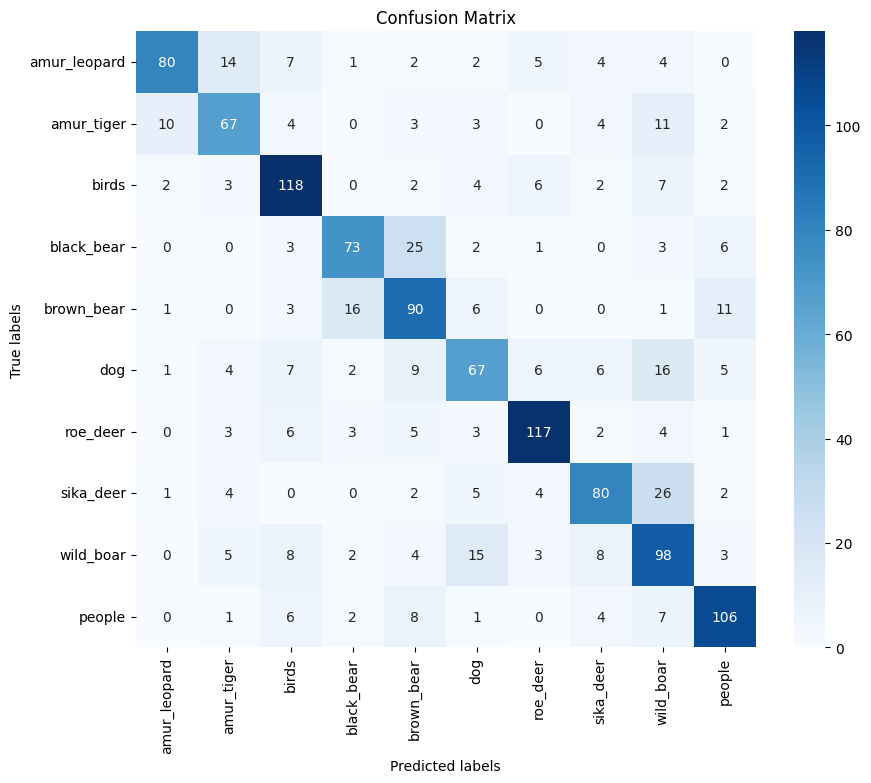

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
classes = ['amur_leopard', 'amur_tiger', 'birds', 'black_bear', 'brown_bear', 'dog', 'roe_deer', 'sika_deer', 'wild_boar', 'people']
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session!pip install wandb onnx -Uq


In [ ]:
!pip install wandb onnx -Uq


In [ ]:
list_dir = []
i = 0
for dirname, _, filenames in os.walk('/kaggle/input/cropped-final/Cropped_final/'):
    if(i==0):
        i+=1
        continue
    else:
        list_dir.append(dirname)
        i+=1
#     print(dirname)
print(list_dir)

['/kaggle/input/cropped-final/Cropped_final/amur_leopard', '/kaggle/input/cropped-final/Cropped_final/dog', '/kaggle/input/cropped-final/Cropped_final/sika_deer', '/kaggle/input/cropped-final/Cropped_final/roe_deer', '/kaggle/input/cropped-final/Cropped_final/amur_tiger', '/kaggle/input/cropped-final/Cropped_final/birds', '/kaggle/input/cropped-final/Cropped_final/wild_boar', '/kaggle/input/cropped-final/Cropped_final/brown_bear', '/kaggle/input/cropped-final/Cropped_final/people', '/kaggle/input/cropped-final/Cropped_final/black_bear']


In [ ]:
for folder in list_dir:
    folder_files = os.listdir(folder)
    print(f"The folder '{folder.split('/')[5]}' has {len(folder_files)} files.")

In [ ]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import wandb
from sklearn.model_selection import train_test_split
from torchvision import transforms

wandb.init(project="my_project_resnet")

class_labels = {
    'amur_leopard': 0,
    'amur_tiger': 1,
    'birds': 2,
    'black_bear': 3,
    'brown_bear': 4,
    'dog': 5,
    'roe_deer': 6,
    'sika_deer': 7,
    'wild_boar': 8,
    'people': 9
}

class CustomDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.classes = os.listdir(img_dir)
        print("Classes found:", self.classes)
        self.img_paths = []
        for class_name in self.classes:
            class_dir = os.path.join(img_dir, class_name)
            for img_name in os.listdir(class_dir):
                self.img_paths.append(os.path.join(class_dir, img_name))

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        label = self.classes.index(img_path.split('/')[-2])
        img = Image.open(os.path.join(self.img_dir, img_path))
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.img_paths)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
dataset = CustomDataset('/kaggle/input/cropped-final/Cropped_final', transform=transform)

length = len(dataset)
train_size = int(length*0.7)
val_size = int(length*0.1)
test_size = length - train_size - val_size
sum_all = train_size + test_size + val_size
# print(sum_all)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])


wandb: Currently logged in as: aditya-arya3131 (adi_1616). Use `wandb login --relogin` to force relogin


Classes found: ['amur_leopard', 'dog', 'sika_deer', 'roe_deer', 'amur_tiger', 'birds', 'wild_boar', 'brown_bear', 'people', 'black_bear']


In [ ]:
len(train_dataset)

8977

In [ ]:
wandb.config = {
    "learning_rate": 0.001,
    "epochs": 100,
    "batch_size": 128,
    "epochs": 10
}

In [ ]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

def get_data():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    dataset = datasets.ImageFolder('/kaggle/input/cropped-final/Cropped_final', transform=transform)

    train_prop = 0.7
    val_prop = 0.1
    test_prop = 0.2

    length = len(dataset)
    train_size = int(length*train_prop)
    val_size = int(length*val_prop)
    test_size = length - train_size - val_size
    sum_all = train_size + val_size + test_size
#     print(sum_all)
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
#     print(len(train_dataset))
    train_loader = DataLoader(train_dataset, batch_size=wandb.config["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=wandb.config["batch_size"], shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=wandb.config["batch_size"], shuffle=False)

    return train_loader, val_loader, test_loader


In [ ]:
train_loader, val_loader, test_loader = get_data()

In [ ]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torchvision.models as models
import torchvision.models as models
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

resnet18 = models.resnet18(pretrained=True)

for param in resnet18.parameters():
    param.requires_grad = False
resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet18 = resnet18.to(device)

summary(resnet18, input_size=(3, 224, 224))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
import torch.optim as optim
from sklearn.metrics import accuracy_score
print(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=wandb.config["learning_rate"])

cuda


In [ ]:
from tqdm import tqdm
for epoch in range(wandb.config["epochs"]):
    resnet18.train()
    train_loss = 0.0
    i = 0
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        #         if(i==5):
        #             break
        #         i+=1
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = resnet18(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss = train_loss + loss.item()
    print("the no of epochs: ", epoch)
    resnet18.eval()
    with torch.no_grad():
        all_preds = []
        all_targets = []
        for data, target in tqdm(val_loader, total=len(val_loader)):
            data, target = data.to(device), target.to(device)
            output = resnet18(data)
            _, preds = torch.max(output, 1)
            p_c = preds.cpu()
            pred_cpu_numpy = p_c.numpy()
            all_preds.extend(p_c)
            t_c = target.cpu()
            target_cpu_numpy = t_c.numpy()
            all_targets.extend(target_cpu_numpy)
        val_accuracy = accuracy_score(all_targets, all_preds)

    wandb.log({"train_loss": train_loss / len(train_loader), "val_accuracy": val_accuracy})

# Finish WandB run
wandb.finish()

100%|██████████| 71/71 [01:40<00:00,  1.41s/it]


the no of epochs:  0


100%|██████████| 71/71 [01:33<00:00,  1.31s/it]


the no of epochs:  1


100%|██████████| 71/71 [01:33<00:00,  1.31s/it]


the no of epochs:  2


100%|██████████| 71/71 [01:33<00:00,  1.31s/it]


the no of epochs:  3


100%|██████████| 71/71 [01:33<00:00,  1.31s/it]


the no of epochs:  4


100%|██████████| 71/71 [01:33<00:00,  1.31s/it]


the no of epochs:  5


100%|██████████| 71/71 [01:34<00:00,  1.33s/it]


the no of epochs:  6


100%|██████████| 71/71 [01:33<00:00,  1.31s/it]


the no of epochs:  7


100%|██████████| 71/71 [01:33<00:00,  1.32s/it]


the no of epochs:  8


100%|██████████| 71/71 [01:34<00:00,  1.33s/it]


the no of epochs:  9


100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▅▇▇▇▇███
train_loss,0.53474
val_accuracy,0.80109


In [ ]:
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(all_targets, all_preds)
print(f'Accuracy: {accuracy}')
f1 = f1_score(all_targets, all_preds, average='weighted')
print(f'F1 Score: {f1}')

Accuracy: 0.8010920436817472
F1 Score: 0.7987961553744557


Text(0.5, 1.0, 'Confusion Matrix')

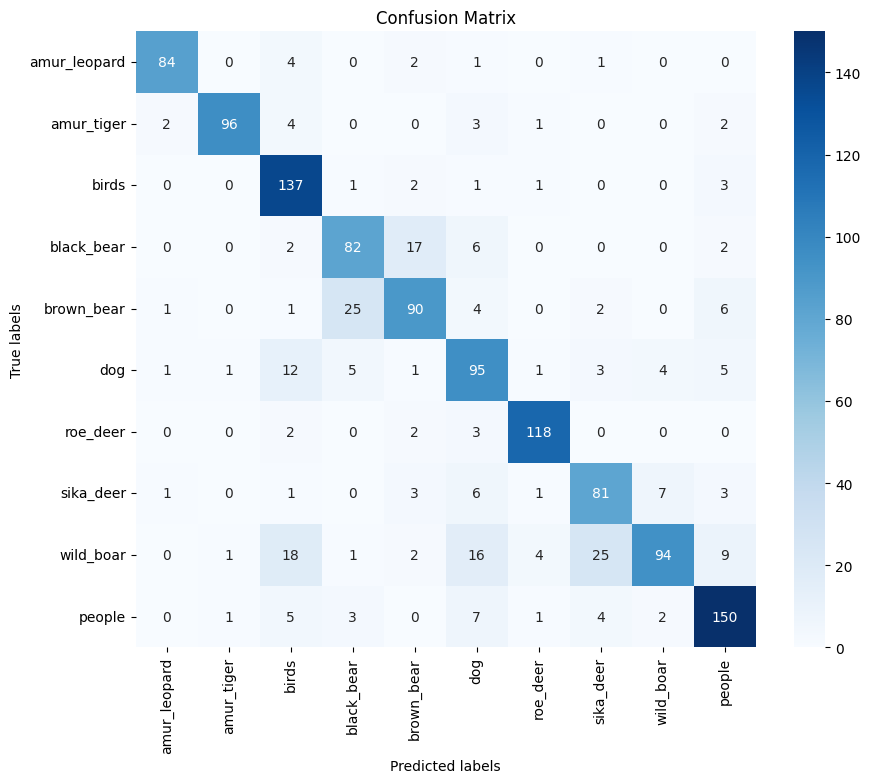

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
classes = ['amur_leopard', 'amur_tiger', 'birds', 'black_bear', 'brown_bear', 'dog', 'roe_deer', 'sika_deer', 'wild_boar', 'people']
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
def extract_features(loader):
    resnet18.eval()
    all_features = []
    all_targets = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            features = resnet18(data)
            f_c = features.cpu()
            features_cpu_numpy = f_c.numpy()
            all_features.extend(features_cpu_numpy)
            t_c = target.cpu()
            target_cpu_numpy = t_c.numpy()
            all_targets.extend(target_cpu_numpy)
    return all_features, all_targets

train_features, train_targets = extract_features(train_loader)
val_features, val_targets = extract_features(val_loader)


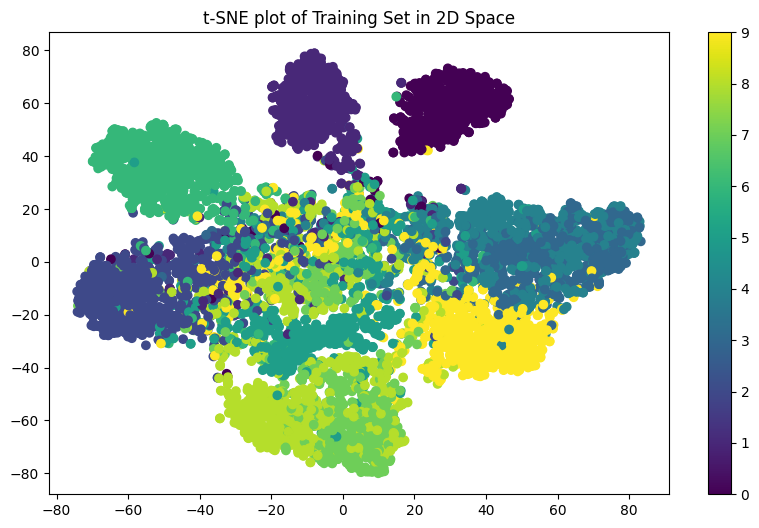

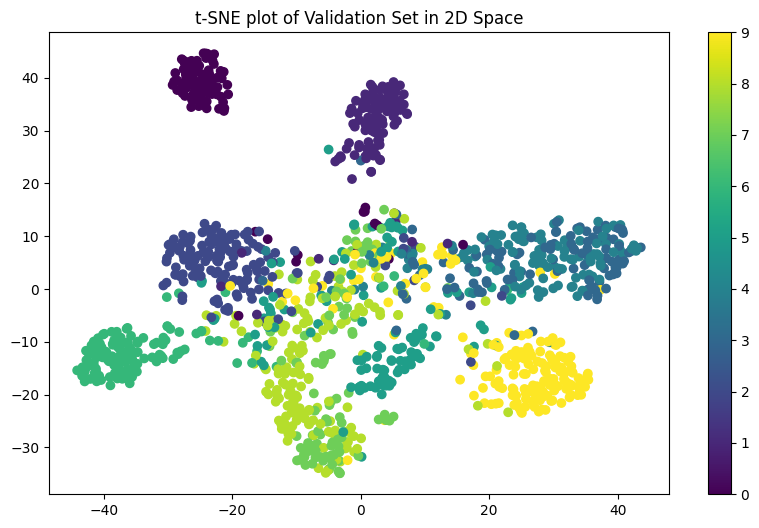

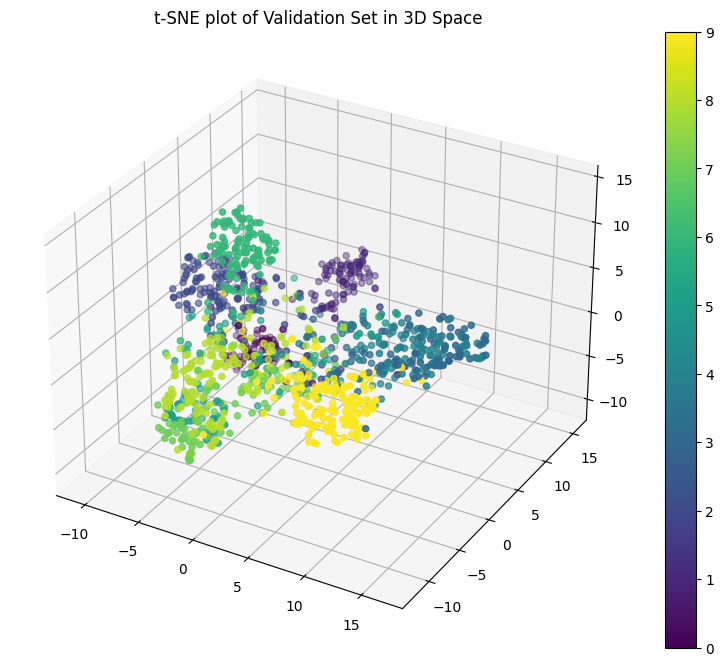

In [ ]:
train_features = np.array(train_features)
val_features = np.array(val_features)

tsne = TSNE(n_components=2, random_state=42)
train_features_tsne = tsne.fit_transform(train_features)
val_features_tsne = tsne.fit_transform(val_features)

plt.figure(figsize=(10, 6))
plt.scatter(train_features_tsne[:, 0], train_features_tsne[:, 1], c=train_targets, cmap='viridis')
plt.title('t-SNE plot of Training Set in 2D Space')
plt.colorbar()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(val_features_tsne[:, 0], val_features_tsne[:, 1], c=val_targets, cmap='viridis')
plt.title('t-SNE plot of Validation Set in 2D Space')
plt.colorbar()
plt.show()

tsne_3d = TSNE(n_components=3, random_state=42)
val_features_tsne_3d = tsne_3d.fit_transform(val_features)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(val_features_tsne_3d[:, 0], val_features_tsne_3d[:, 1], val_features_tsne_3d[:, 2], c=val_targets, cmap='viridis')
plt.title('t-SNE plot of Validation Set in 3D Space')
plt.colorbar(sc)
plt.show()

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install wandb onnx -Uq

In [ ]:
import os
list_dir = []
i = 0
for dirname, _, filenames in os.walk('/kaggle/input/cropped-final/Cropped_final/'):
    if(i==0):
        i+=1
        continue
    else:
        list_dir.append(dirname)
        i+=1
#     print(dirname)
print(list_dir)

['/kaggle/input/cropped-final/Cropped_final/amur_leopard', '/kaggle/input/cropped-final/Cropped_final/dog', '/kaggle/input/cropped-final/Cropped_final/sika_deer', '/kaggle/input/cropped-final/Cropped_final/roe_deer', '/kaggle/input/cropped-final/Cropped_final/amur_tiger', '/kaggle/input/cropped-final/Cropped_final/birds', '/kaggle/input/cropped-final/Cropped_final/wild_boar', '/kaggle/input/cropped-final/Cropped_final/brown_bear', '/kaggle/input/cropped-final/Cropped_final/people', '/kaggle/input/cropped-final/Cropped_final/black_bear']


In [ ]:
for folder in list_dir:
    folder_files = os.listdir(folder)
    print(f"The folder '{folder.split('/')[5]}' has {len(folder_files)} files.")

The folder 'amur_leopard' has 1028 files.
The folder 'dog' has 1263 files.
The folder 'sika_deer' has 1589 files.
The folder 'roe_deer' has 1174 files.
The folder 'amur_tiger' has 1099 files.
The folder 'birds' has 1496 files.
The folder 'wild_boar' has 1475 files.
The folder 'brown_bear' has 1259 files.
The folder 'people' has 1417 files.
The folder 'black_bear' has 1025 files.


In [ ]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import wandb
from sklearn.model_selection import train_test_split
from torchvision import transforms

wandb.init(project="my_project_resnet")

class_labels = {
    'amur_leopard': 0,
    'amur_tiger': 1,
    'birds': 2,
    'black_bear': 3,
    'brown_bear': 4,
    'dog': 5,
    'roe_deer': 6,
    'sika_deer': 7,
    'wild_boar': 8,
    'people': 9
}

class CustomDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.classes = os.listdir(img_dir)
        print("Classes found:", self.classes)
        self.img_paths = []
        for class_name in self.classes:
            class_dir = os.path.join(img_dir, class_name)
            for img_name in os.listdir(class_dir):
                self.img_paths.append(os.path.join(class_dir, img_name))

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        label = self.classes.index(img_path.split('/')[-2])
        img = Image.open(os.path.join(self.img_dir, img_path))
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.img_paths)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = CustomDataset('/kaggle/input/cropped-final/Cropped_final', transform=transform)

length = len(dataset)
train_size = int(length*0.7)
val_size = int(length*0.1)
test_size = length - train_size - val_size
sum_all = train_size + test_size + val_size
# print(sum_all)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Classes found: ['amur_leopard', 'dog', 'sika_deer', 'roe_deer', 'amur_tiger', 'birds', 'wild_boar', 'brown_bear', 'people', 'black_bear']


In [ ]:
wandb.config = {
    "learning_rate": 0.001,
    "epochs": 100,
    "batch_size": 128,
    "epochs": 10
}

In [ ]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from torchvision import transforms as torchvision_transforms

def random_horizontal_flip(image):
    if  0.5 < torch.rand(1):
        return torchvision_transforms.functional.hflip(image)
    else:
        return image
def random_rotation(image, angle_range=15):
    angle = torch.randint(-angle_range, angle_range + 1, (1,))
    return torchvision_transforms.functional.rotate(image, angle.item())

def random_vertical_flip(image):
    if 0.5 < torch.rand(1):
        return torchvision_transforms.functional.vflip(image)
    else:
        return image

def my_transform(image):
    base_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = base_transform(image)

    image = random_horizontal_flip(image)

    image = random_rotation(image)

    image = random_vertical_flip(image)

    return image

def get_data_new():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    dataset = datasets.ImageFolder('/kaggle/input/cropped-final/Cropped_final', transform=my_transform)

    train_prop = 0.7
    val_prop = 0.1
    test_prop = 0.2
    length = len(dataset)
    train_size = int(length*train_prop)
    val_size = int(length*val_prop)
    test_size = length - train_size - val_size
    sum_all = train_size + val_size + test_size
#     print(sum_all)
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
#     print(len(train_dataset))
    train_loader = DataLoader(train_dataset, batch_size=wandb.config["batch_size"], shuffle=True)
#     print(len(train_loader))
    val_loader = DataLoader(val_dataset, batch_size=wandb.config["batch_size"], shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=wandb.config["batch_size"], shuffle=False)

    return train_loader, val_loader, test_loader

In [ ]:
wandb.init(project='my_project_resnet_augment')
wandb.config = {
    "learning_rate": 0.001,
    "epochs": 100,
    "batch_size": 128,
    "epochs": 10
}
train_loader_new, val_loader_new, test_loader_new = get_data_new()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=4)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(25088, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        # print("After conv1:", x.shape)
        x = self.pool1(x)
        # print("After pool1:", x.shape)
        x = F.relu(self.conv2(x))
        # print("After conv2:", x.shape)
        x = self.pool2(x)
        # print("After pool2:", x.shape)
        x = F.relu(self.conv3(x))
        # print("After conv3:", x.shape)
        x = self.pool3(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        # print("After fc1:", x.shape)
        x = self.fc2(x)
        # print("After fc2:", x.shape)
        return x

custom_cnn = CustomCNN()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
custom_cnn.to(device)
summary(custom_cnn, input_size=(3, 224, 224))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
         MaxPool2d-2           [-1, 32, 56, 56]               0
            Conv2d-3           [-1, 64, 56, 56]          18,496
         MaxPool2d-4           [-1, 64, 28, 28]               0
            Conv2d-5          [-1, 128, 28, 28]          73,856
         MaxPool2d-6          [-1, 128, 14, 14]               0
            Linear-7                  [-1, 256]       6,422,784
            Linear-8                   [-1, 10]           2,570
Total params: 6,518,602
Trainable params: 6,518,602
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 15.89
Params size (MB): 24.87
Estimated Total Size (MB): 41.33
----------------------------------------------------------------


In [ ]:
import torch.optim as optim
from sklearn.metrics import accuracy_score
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_cnn.parameters(), lr=wandb.config["learning_rate"])

In [ ]:
from tqdm import tqdm
for epoch in range(wandb.config["epochs"]):
    custom_cnn.train()
    train_loss = float(0)
    len_train = len(train_loader_new)
    i = 0
    for batch_idx, (data, target) in tqdm(enumerate(train_loader_new), len_train):
#         if(i==5):
#             break
#         i+=1
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = custom_cnn(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss = train_loss + loss.item()
    print("the no of epochs: ", epoch)
    custom_cnn.eval()
    with torch.no_grad():
        all_preds = []
        all_targets = []
        len_val = len(val_loader_new)
        for data, target in tqdm(val_loader_new, total=len_val):
            data, target = data.to(device), target.to(device)
            output = custom_cnn(data)
            _, preds = torch.max(output, 1)
            p_c = preds.cpu()
            pred_cpu_numpy = p_c.numpy()
            all_preds.extend(p_c)
            t_c = target.cpu()
            target_cpu_numpy = t_c.numpy()
            all_targets.extend(target_cpu_numpy)
        val_accuracy = accuracy_score(all_targets, all_preds)

    wandb.log({"train_loss": train_loss / len(train_loader), "val_accuracy": val_accuracy})

wandb.finish()

100%|██████████| 71/71 [02:14<00:00,  1.89s/it]


the no of epochs:  0


100%|██████████| 71/71 [01:39<00:00,  1.40s/it]


the no of epochs:  1


100%|██████████| 71/71 [01:39<00:00,  1.40s/it]


the no of epochs:  2


100%|██████████| 71/71 [01:40<00:00,  1.41s/it]


the no of epochs:  3


100%|██████████| 71/71 [01:38<00:00,  1.39s/it]


the no of epochs:  4


100%|██████████| 71/71 [01:38<00:00,  1.39s/it]


the no of epochs:  5


100%|██████████| 71/71 [01:38<00:00,  1.39s/it]


the no of epochs:  6


100%|██████████| 71/71 [01:38<00:00,  1.39s/it]


the no of epochs:  7


100%|██████████| 71/71 [01:39<00:00,  1.40s/it]


the no of epochs:  8


100%|██████████| 71/71 [01:40<00:00,  1.42s/it]


the no of epochs:  9


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▄▅▅▆▇▇▇██
train_loss,0.93385
val_accuracy,0.60686


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

accuracy = accuracy_score(all_targets, all_preds)
print(f'Accuracy: {accuracy}')
f1 = f1_score(all_targets, all_preds, average='weighted')
print(f'F1 Score: {f1}')

Accuracy: 0.6068642745709828
F1 Score: 0.6076482654633393


Text(0.5, 1.0, 'Confusion Matrix')

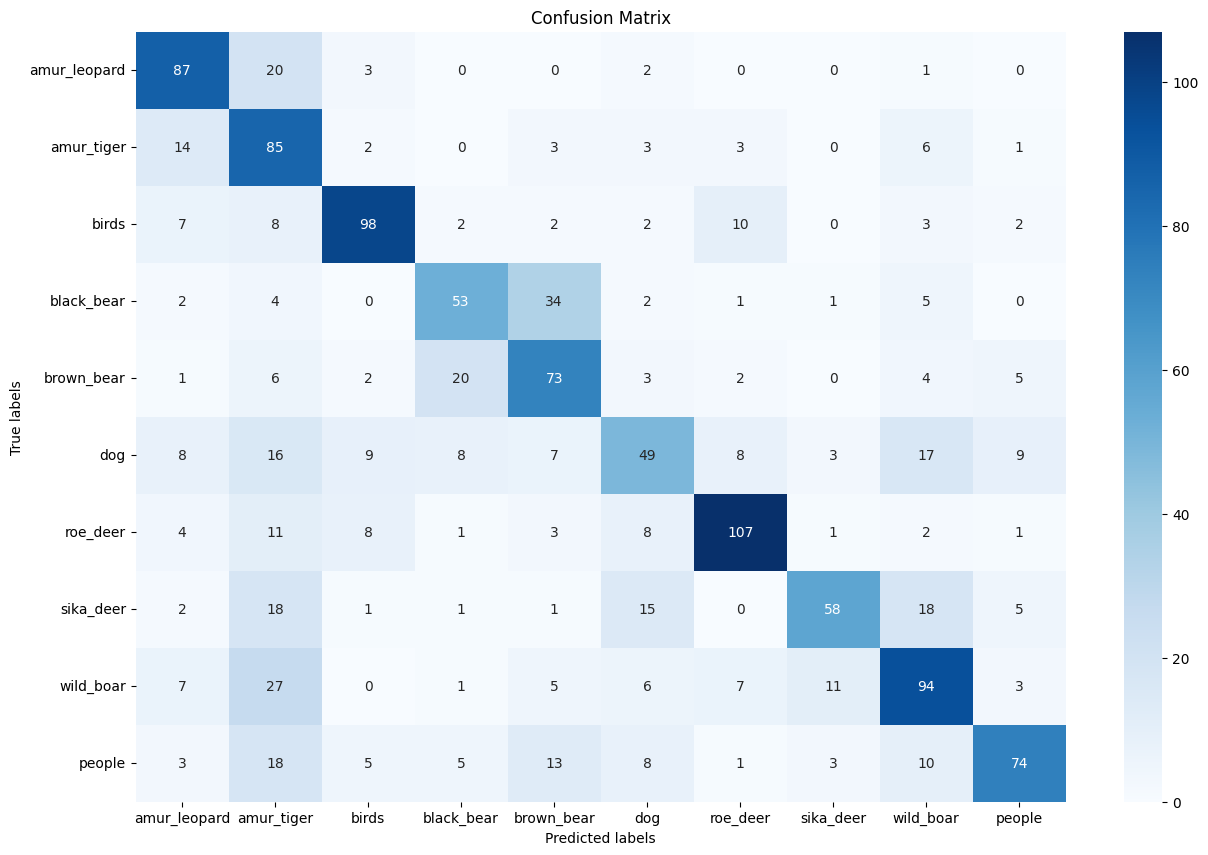

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
classes = ['amur_leopard', 'amur_tiger', 'birds', 'black_bear', 'brown_bear', 'dog', 'roe_deer', 'sika_deer', 'wild_boar', 'people']
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')